## MNISTで多クラス分類

In [1]:
import numpy as np
import torch
from torch.nn import functional as F
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### ベースの学習ループ

In [2]:
# 1. データロード
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

(1797, 8, 8)


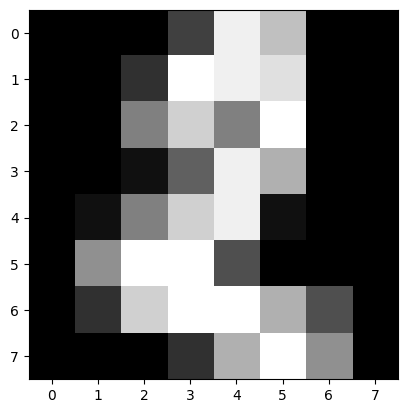

In [3]:
# データ可視化
plt.imshow(images[2], cmap='gray')
print(images.shape)

In [4]:
# 正解ラベル
target

array([0, 1, 2, ..., 8, 9, 8])

In [5]:
# 2. 前処理
# 2-1.ラベルのone-hot encoing
y_true = F.one_hot(torch.tensor(target), num_classes=10)
# NumPyのデフォルトはfloat64, torchはfloat32で，演算時にエラーになるのでfloat32に揃える
images = torch.tensor(images, dtype=torch.float32).reshape(-1, 64)
# 2-2. 画像の標準化
images = (images - images.mean()) / images.std()

In [6]:
learning_rate = 0.03
loss_log = []

In [7]:
# 3. パラメータの初期化
W = torch.rand((10, 64), requires_grad=True) # 出力x入力
b = torch.rand((1, 10), requires_grad=True) # 1 x 出力

In [8]:
# 4. softmaxとcross entropy
def softmax(x):
    e_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])
    return e_x / (torch.sum(e_x, dim=-1, keepdim=True) + 1e-10)

def cross_entropy(y_true, y_pred):
    return -torch.sum(y_true * torch.log(y_pred + 1e-10)) / y_true.shape[0]

In [9]:
# 5. for文で学習ループ作成
for epoch in range(5):
    running_loss = 0
    for i in range(len(target)):
        # 6. 入力データXおよび教師ラベルのYを作成
        y_true_ = y_true[i].reshape(-1, 10) # データ数xクラス数
        X = images[i].reshape(-1, 64) # データ数 x 特徴量数

        # 7. Z計算
        Z = X@W.T + b

        # 8. softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())
        running_loss += loss.item()
        
        # 10. 勾配計算
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # 13. 損失ログ出力
    print(f'epoch: {epoch+1}: {running_loss/len(target)}')
        

epoch: 1: 0.39656129619975555
epoch: 2: 0.13853320235406702
epoch: 3: 0.10807288386777535
epoch: 4: 0.09149437798308079
epoch: 5: 0.08024101983448537


In [10]:
# 学習したモデルで全データのaccuracyを計算する（学習に使っているデータに対してのAccuracyであることに注意）
X = torch.tensor(images, dtype=torch.float32)
Z = X@W.T + b
y_pred = softmax(Z)
# accuracy = 正しく分類できた数/全サンプル数
torch.sum(torch.argmax(y_pred, dim=-1) == torch.argmax(y_true, dim=-1)) / y_true.shape[0]

/tmp/ipykernel_1237/844738670.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(images, dtype=torch.float32)


tensor(0.9755)

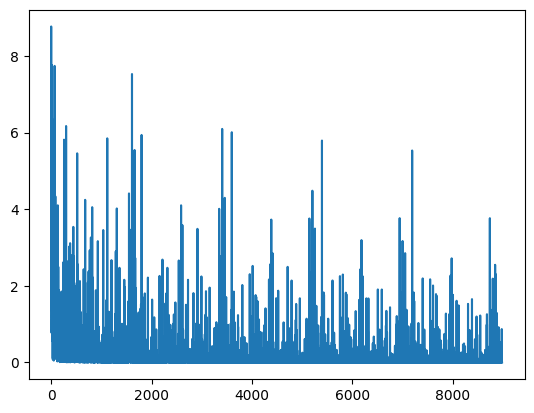

In [11]:
plt.plot(loss_log)

### mini-batch学習

In [12]:
# ランダムにソートされたindexを使ってデータを取得することで，X, yを同時にshuffleすることが可能
np.random.permutation(len(target))

array([ 331, 1434,  213, ...,  811, 1723, 1050])

In [13]:
loss_log = []
batch_size = 30
num_batches = np.ceil(len(target) / batch_size).astype(int)
# 3. パラメータの初期化
W = torch.rand((10, 64), requires_grad=True) # 出力x入力
b = torch.rand((1, 10), requires_grad=True) # 1 x 出力
# 5. for文で学習ループ作成
for epoch in range(5):
    shuffled_indices = np.random.permutation(len(target))
    running_loss = 0
    for i in range(num_batches):

        # mini batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indices[start:end]
        # 6. 入力データXおよび教師ラベルのYを作成
        y_true_ = y_true[batch_indices, :] # データ数xクラス数
        X = images[batch_indices, :] # データ数 x 特徴量数
        # ブレークポイントを設置
        # import pdb; pdb.set_trace()

        # 7. Z計算
        Z = X@W.T + b

        # 8. softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())
        running_loss += loss.item()
        
        # 10. 勾配計算
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

    # 13. 損失ログ出力
    print(f'epoch: {epoch+1}: {running_loss/num_batches}')

epoch: 1: 2.417827280362447
epoch: 2: 1.1163650155067444
epoch: 3: 0.7393498991926511
epoch: 4: 0.5697161932786305
epoch: 5: 0.4747459597885609


In [14]:
X = torch.tensor(images, dtype=torch.float32)
Z = X@W.T + b
y_pred = softmax(Z)
# Accuracy
torch.sum(torch.argmax(y_pred, dim=-1) == torch.argmax(y_true, dim=-1)) / y_true.shape[0]

/tmp/ipykernel_1237/3927234863.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(images, dtype=torch.float32)


tensor(0.8865)

### 学習データと検証データを分ける

In [15]:
# 1. データロード
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

In [16]:
# 学習データと検証データ分割
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1437, 8, 8) (1437,)
(360, 8, 8) (360,)


In [17]:
# 前処理
# 2-1.ラベルのone-hot encoing
y_train = F.one_hot(torch.tensor(y_train), num_classes=10)
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)

y_val = F.one_hot(torch.tensor(y_val), num_classes=10)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

# 2-2. 画像の標準化
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_train.mean()) / X_train.std()
# 以下のように手元のデータ全ての平均&標準偏差を使えば，学習データと検証データの分布を近くすることが可能
# しかし，この場合validationの精度は，未知のデータよりも若干高くなることに注意
# X_train = (X_train - images.mean()) / images.std()
# X_val = (X_val - images.mean()) / images.std()

In [18]:
print(X_train.mean(), X_val.mean())

tensor(6.9020e-08) tensor(4.8559)


In [19]:
batch_size = 30
num_batches = np.ceil(len(y_train) / batch_size).astype(int)
loss_log = []
# 3. パラメータの初期化
W = torch.rand((10, 64), requires_grad=True) # 出力x入力
b = torch.rand((1, 10), requires_grad=True) # 1 x 出力
# ログ
train_losses = []
val_losses = []
val_accuracies = []
# 5. for文で学習ループ作成
epochs = 30
for epoch in range(epochs):
    shuffled_indices = np.random.permutation(len(y_train))
    running_loss = 0
    for i in range(num_batches):

        # mini batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indices[start:end]
        # 6. 入力データXおよび教師ラベルのYを作成
        y_true_ = y_train[batch_indices, :] # データ数xクラス数
        X = X_train[batch_indices, :] # データ数 x 特徴量数
        # import pdb; pdb.set_trace()

        # 7. Z計算
        Z = X@W.T + b

        # 8. softmaxで予測計算
        y_pred = softmax(Z)

        # 9. 損失計算
        loss = cross_entropy(y_true_, y_pred)
        loss_log.append(loss.item())
        running_loss += loss.item()
        
        # 10. 勾配計算
        loss.backward()

        # 11. パラメータ更新
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 12. 勾配初期化
        W.grad.zero_()
        b.grad.zero_()
    # validation
    with torch.no_grad():
        Z_val = X_val@W.T + b
        y_pred_val = softmax(Z_val)

        val_loss = cross_entropy(y_val, y_pred_val)
        val_accuracy = torch.sum(torch.argmax(y_pred_val, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())
        
    # 13. 損失ログ出力
    print(f'epoch: {epoch+1}: train loss:{running_loss/num_batches}, val loss: {val_loss.item()}, val accuracy: {val_accuracy.item()}')

epoch: 1: train loss:2.5727387790878615, val loss: 9.850950241088867, val accuracy: 0.29722222685813904
epoch: 2: train loss:1.3422037151952584, val loss: 5.8252644538879395, val accuracy: 0.4472222328186035
epoch: 3: train loss:0.8980314917862415, val loss: 3.672231435775757, val accuracy: 0.5805555582046509
epoch: 4: train loss:0.6879242385427157, val loss: 2.5832886695861816, val accuracy: 0.6777777671813965
epoch: 5: train loss:0.5680481431384882, val loss: 1.9716659784317017, val accuracy: 0.7333333492279053
epoch: 6: train loss:0.4907635835309823, val loss: 1.6233280897140503, val accuracy: 0.7722222208976746
epoch: 7: train loss:0.4366974054525296, val loss: 1.3963754177093506, val accuracy: 0.800000011920929
epoch: 8: train loss:0.39521010251094896, val loss: 1.242463231086731, val accuracy: 0.8333333134651184
epoch: 9: train loss:0.36402303632348776, val loss: 1.1189461946487427, val accuracy: 0.8444444537162781
epoch: 10: train loss:0.3384400174642603, val loss: 0.99989163875

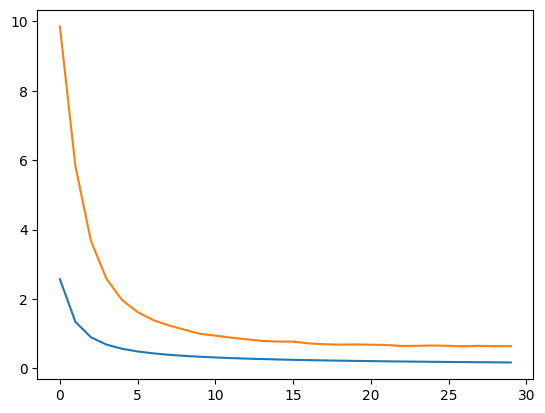

In [20]:
plt.plot(train_losses)
plt.plot(val_losses)